Dataset Import

In [ ]:
import kagglehub
path = kagglehub.dataset_download("paridhijain02122001/cotton-crop-disease-detection")
print("Path to dataset files:", path)

100%|██████████| 656M/656M [00:06<00:00, 110MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1


Required Libraries

In [ ]:
!pip install torch torchvision matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm

Device Select

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Directory Loading

In [ ]:
train_dir = '/root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/train'
test_dir = '/root/.cache/kagglehub/datasets/paridhijain02122001/cotton-crop-disease-detection/versions/1/test'

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=transform['train'])
test_data = datasets.ImageFolder(test_dir, transform=transform['test'])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

DenseNet121

In [ ]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s]


In [ ]:
num_classes = len(train_data.classes)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

best_test_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

num_epochs = 5

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = test_loader

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        with torch.set_grad_enabled(phase == 'train'):
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()}"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()
                total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            test_losses.append(epoch_loss)
            test_accuracies.append(epoch_acc)

            # Save best model
            if epoch_acc > best_test_acc:
                best_test_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "best_model.pth")
                print(f"✅ Best model saved at epoch {epoch+1} with val acc: {best_test_acc:.4f}")

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# Load best weights after training
model.load_state_dict(best_model_wts)


Epoch 1/5
------------------------------


Train: 100%|██████████| 270/270 [43:31<00:00,  9.67s/it]


Train Loss: 0.6062 | Accuracy: 0.7891


Val: 100%|██████████| 23/23 [02:56<00:00,  7.67s/it]


✅ Best model saved at epoch 1 with val acc: 0.9279
Val Loss: 0.2082 | Accuracy: 0.9279

Epoch 2/5
------------------------------


Train: 100%|██████████| 270/270 [41:46<00:00,  9.29s/it]


Train Loss: 0.3211 | Accuracy: 0.8875


Val: 100%|██████████| 23/23 [02:52<00:00,  7.51s/it]


✅ Best model saved at epoch 2 with val acc: 0.9376
Val Loss: 0.1867 | Accuracy: 0.9376

Epoch 3/5
------------------------------


Train: 100%|██████████| 270/270 [44:26<00:00,  9.87s/it]


Train Loss: 0.2536 | Accuracy: 0.9149


Val: 100%|██████████| 23/23 [03:11<00:00,  8.34s/it]


Val Loss: 0.2292 | Accuracy: 0.9182

Epoch 4/5
------------------------------


Train: 100%|██████████| 270/270 [45:20<00:00, 10.08s/it]


Train Loss: 0.2217 | Accuracy: 0.9230


Val: 100%|██████████| 23/23 [03:20<00:00,  8.70s/it]


✅ Best model saved at epoch 4 with val acc: 0.9639
Val Loss: 0.1252 | Accuracy: 0.9639

Epoch 5/5
------------------------------


Train: 100%|██████████| 270/270 [41:45<00:00,  9.28s/it]


Train Loss: 0.2123 | Accuracy: 0.9244


Val: 100%|██████████| 23/23 [02:44<00:00,  7.16s/it]

Val Loss: 0.1296 | Accuracy: 0.9542


<All keys matched successfully>

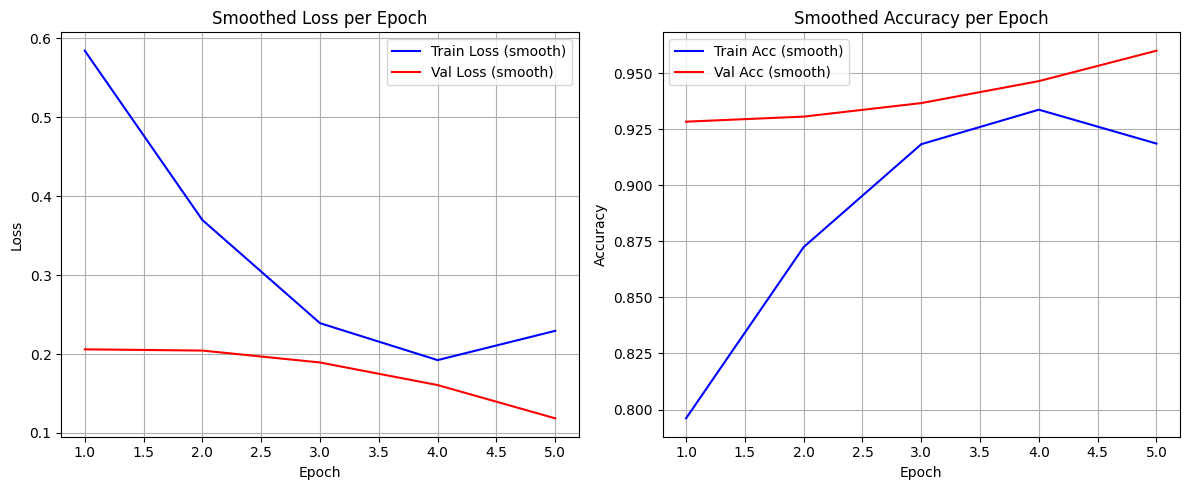

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Smooth the curves using Savitzky-Golay filter
def smooth_curve(values, window=5, poly=2):
    if len(values) >= window:
        return savgol_filter(values, window_length=window, polyorder=poly)
    return values  # return unsmoothed if not enough points

# Smooth your data
train_losses_smooth = smooth_curve(train_losses)
val_losses_smooth = smooth_curve(test_losses)
train_acc_smooth = smooth_curve(train_accuracies)
val_acc_smooth = smooth_curve(test_accuracies)

# Plotting
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_smooth, 'b-', label='Train Loss (smooth)')
plt.plot(epochs, val_losses_smooth, 'r-', label='Val Loss (smooth)')
plt.title("Smoothed Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_smooth, 'b-', label='Train Acc (smooth)')
plt.plot(epochs, val_acc_smooth, 'r-', label='Val Acc (smooth)')
plt.title("Smoothed Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
class_names = test_loader.dataset.classes

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

          Aphids       0.91      0.99      0.95       120
       Army_worm       0.99      0.99      0.99       120
Bacterial_Blight       0.96      0.88      0.92       120
         Healthy       0.98      1.00      0.99       120
  Powdery_Mildew       0.99      0.98      0.99       120
     Target_spot       0.96      0.93      0.95       121

        accuracy                           0.96       721
       macro avg       0.96      0.96      0.96       721
    weighted avg       0.96      0.96      0.96       721



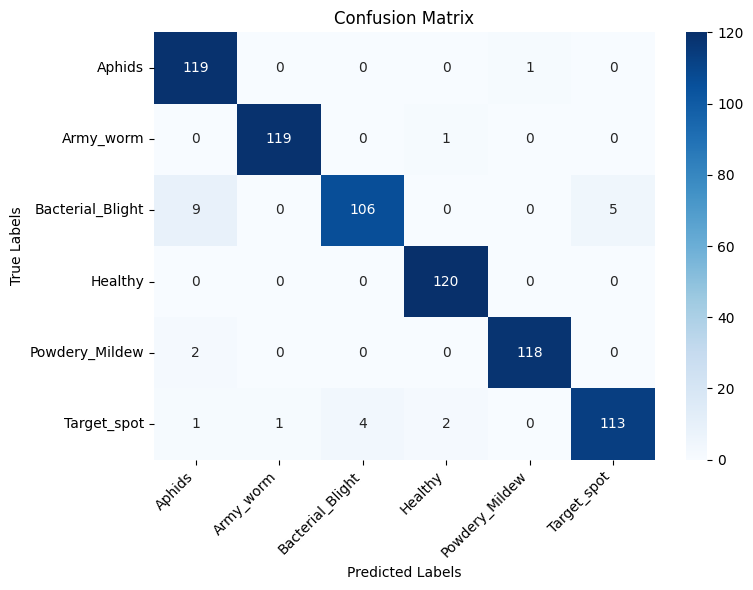

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Set the tick labels manually
ax.set_xticks(np.arange(len(class_names)) + 0.5)
ax.set_yticks(np.arange(len(class_names)) + 0.5)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()
